In [36]:
import kedro
print("✅ Kedro version:", kedro.__version__)


✅ Kedro version: 1.0.0


In [37]:
from kedro.framework.startup import bootstrap_project
from kedro.framework.project import configure_project
from kedro.framework.session import KedroSession

bootstrap_project("..")
configure_project("analisis")

with KedroSession(session_id="notebook") as session:
    context = session.load_context()
    catalog = context.catalog

print("🎯 Catálogo cargado con éxito")


[10/23/25 23:09:32] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=900522;file://c:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\.venv\Lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=929455;file://c:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\.venv\Lib\site-packages\kedro_telemetry\plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

🎯 Catálogo cargado con éxito


In [38]:
import yaml
from pathlib import Path

catalog_path = Path("../conf/base/catalog.yml")  # Ajusta según la ruta
with open(catalog_path, "r", encoding="utf-8") as f:
    catalog_yaml = yaml.safe_load(f)

print(list(catalog_yaml.keys()))


['matriz_compra', 'matriz_venta', 'matriz_venta_clean', 'matriz_compra_clean', 'matriz_venta_filtrada', 'matriz_compra_filtrada', 'matriz_venta_normalizada', 'matriz_compra_normalizada', 'matriz_venta_datos_normalizada', 'matriz_compra_datos_normalizada', 'matriz_de_datos_unificada_emparejada', 'matriz_de_datos_ordenada']


In [39]:
import pandas as pd
import re

def extraer_peso_y_limpiar_productos_v3(df: pd.DataFrame) -> pd.DataFrame:
    """
    Limpia los nombres de productos, extrae el peso en KG (maneja decimales) y crea un nombre base.
    """
    def extraer_peso(nombre: str) -> float:
        nombre = nombre.upper()
        # KG con decimales (punto o coma)
        match_kg = re.search(r'(\d+[.,]?\d*)\s*KG', nombre)
        if match_kg:
            return float(match_kg.group(1).replace(',', '.'))
        # GR con decimales
        match_gr = re.search(r'(\d+[.,]?\d*)\s*GR', nombre)
        if match_gr:
            return float(match_gr.group(1).replace(',', '.')) / 1000
        # Formato tipo 12X85 (sin GR)
        match_mult = re.search(r'(\d+)\s*X\s*(\d+)', nombre)
        if match_mult:
            return float(match_mult.group(1)) * float(match_mult.group(2)) / 1000
        return None

    # Limpiar nombre
    df["PRODUCTO"] = df["PRODUCTO"].str.strip().str.upper()
    df["PESO_KG"] = df["PRODUCTO"].apply(extraer_peso)

    # Limpiar PRODUCTO_BASE eliminando peso y números de paquete
    df["PRODUCTO_BASE"] = df["PRODUCTO"]\
        .str.replace(r'X\s*\d+(\s*(KG|GR))?', '', regex=True)\
        .str.replace(r'\d+\s*X\s*\d+', '', regex=True)\
        .str.replace(r'\d+[.,]?\d*KG', '', regex=True)\
        .str.replace(r'\d+', '', regex=True)\
        .str.strip()

    return df


In [40]:
# Supongamos que tenemos los datasets ya limpios
import pandas as pd

# Cargar datasets limpios
venta_clean = pd.read_parquet("C:/Users/raulr/OneDrive/Escritorio/ProyectoAllendesKedro/analisis/data/02_intermediate/extraer_peso_y_limpiar_productos_venta_node.parquet")
compra_clean = pd.read_parquet("C:/Users/raulr/OneDrive/Escritorio/ProyectoAllendesKedro/analisis/data/02_intermediate/extraer_peso_y_limpiar_productos_compra_node.parquet")

# Definir rangos razonables de peso (en KG)
peso_min_venta, peso_max_venta = 0.01, 50
peso_min_compra, peso_max_compra = 0.01, 100

# Filtrar productos atípicos
venta_atipica = venta_clean[(venta_clean["PESO_KG"] < peso_min_venta) | (venta_clean["PESO_KG"] > peso_max_venta)]
compra_atipica = compra_clean[(compra_clean["PESO_KG"] < peso_min_compra) | (compra_clean["PESO_KG"] > peso_max_compra)]

print("=== Productos de venta con peso atípico ===")
print(venta_atipica[["PRODUCTO", "PESO_KG"]].head(10))

print("\n=== Productos de compra con peso atípico ===")
print(compra_atipica[["PRODUCTO", "PESO_KG"]].head(10))


=== Productos de venta con peso atípico ===
                               PRODUCTO  PESO_KG
739          CREAMY CAT SALMON 1 X 6 UD    0.006
843          CREAMY CAT SALMON 1 X 6 UD    0.006
852   CREAMY CAT POLLO CAMARON 1 X 6 UD    0.006
935          CREAMY CAT SALMON 1 X 6 UD    0.006
954   CREAMY CAT POLLO CAMARON 1 X 6 UD    0.006
965           CREAMY CAT POLLO 1 X 6 UD    0.006
1183  CREAMY CAT POLLO CAMARON 1 X 6 UD    0.006
1264          CREAMY CAT POLLO 1 X 6 UD    0.006
1336          CREAMY CAT POLLO 1 X 6 UD    0.006
1429         CREAMY CAT SALMON 1 X 6 UD    0.006

=== Productos de compra con peso atípico ===
                              PRODUCTO  PESO_KG
13   ELIMINADOR MARCAS 350 CC 4 X 1 UN    0.004
133              BULLY STICK 3 X 3 UND    0.009
149          HUMERO DE CERDO 3 X 3 UND    0.009
164              BULLY STICK 3 X 3 UND    0.009
165          HUMERO DE CERDO 3 X 3 UND    0.009
180  CREAMY CAT POLLO CAMARON 1 X 6 UD    0.006
183          CREAMY CAT POLLO 1 X 6

In [41]:
import pandas as pd

# Cargar los datasets (con rutas corregidas para Windows)
venta_clean = pd.read_parquet(r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\02_intermediate\extraer_peso_y_limpiar_productos_venta_node.parquet")
compra_clean = pd.read_parquet(r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\02_intermediate\extraer_peso_y_limpiar_productos_compra_node.parquet")

# Definir percentiles
p_min = 0.01
p_max = 0.99

# Para ventas
limite_inferior_venta = venta_clean['PESO_KG'].quantile(p_min)
limite_superior_venta = venta_clean['PESO_KG'].quantile(p_max)

# Para compras
limite_inferior_compra = compra_clean['PESO_KG'].quantile(p_min)
limite_superior_compra = compra_clean['PESO_KG'].quantile(p_max)

print("Límites ventas:", limite_inferior_venta, "-", limite_superior_venta)
print("Límites compras:", limite_inferior_compra, "-", limite_superior_compra)

# Filtrado de ventas
venta_filtrada = venta_clean[(venta_clean['PESO_KG'] >= limite_inferior_venta) &
                             (venta_clean['PESO_KG'] <= limite_superior_venta)]

# Filtrado de compras
compra_filtrada = compra_clean[(compra_clean['PESO_KG'] >= limite_inferior_compra) &
                               (compra_clean['PESO_KG'] <= limite_superior_compra)]

print("Filas originales ventas:", len(venta_clean), "-> después del filtrado:", len(venta_filtrada))
print("Filas originales compras:", len(compra_clean), "-> después del filtrado:", len(compra_filtrada))


Límites ventas: 0.085 - 25.0
Límites compras: 0.01 - 25.0
Filas originales ventas: 80508 -> después del filtrado: 76047
Filas originales compras: 11949 -> después del filtrado: 10847


In [42]:
# Ventas
duplicados_ventas = venta_filtrada.duplicated()
print("Filas duplicadas exactas en ventas:", duplicados_ventas.sum())

# Compras
duplicados_compras = compra_filtrada.duplicated()
print("Filas duplicadas exactas en compras:", duplicados_compras.sum())


Filas duplicadas exactas en ventas: 23867
Filas duplicadas exactas en compras: 39


In [43]:
# Ventas
duplicados_productos_ventas = venta_filtrada['PRODUCTO_BASE'].duplicated().sum()
print("Productos repetidos en ventas:", duplicados_productos_ventas)

# Compras
duplicados_productos_compras = compra_filtrada['PRODUCTO_BASE'].duplicated().sum()
print("Productos repetidos en compras:", duplicados_productos_compras)


Productos repetidos en ventas: 75681
Productos repetidos en compras: 10127


In [44]:
# Ventas
repetidos_ventas = venta_filtrada[venta_filtrada['PRODUCTO_BASE'].duplicated(keep=False)]
print(repetidos_ventas[['PRODUCTO', 'PRODUCTO_BASE', 'PESO_KG']].head(20))

# Compras
repetidos_compras = compra_filtrada[compra_filtrada['PRODUCTO_BASE'].duplicated(keep=False)]
print(repetidos_compras[['PRODUCTO', 'PRODUCTO_BASE', 'PESO_KG']].head(20))


                                      PRODUCTO  \
0                   MASTER CAT GATITO 1X20 KG.   
1          MASTERDOG POUCH CACHORRO 20 X 85 GR   
2                 ROYAL CANIN RENAL CAN 1,5 KG   
3            PEDIGREE POUCH SENIOR 12 X 100 GR   
4                        WHISKAS CARNE X 10 KG   
5                             CACHUPIN X 25 KG   
6   PED POUCH ADULTO RAZAS PEQ POLLO 12X100 GR   
7               WHISKAS POUCH CARNE 12 X 85 GR   
8         CHAMPION DOG ADT CARNE&POLLO X 18 KG   
9              MASTER CAT POUCH SALMON 20 X 85   
10   MASTERDOG VETEADO CARNE ARROZ VEG X 18 KG   
11                      BLACK DOG ADULTO 25 KG   
12            MASTERCAT SALMON SARDINA X 20 KG   
13                      MASTER DOG SENIOR 18KG   
14            MASTERCAT SALMON SARDINA X 20 KG   
15                   CHAMPION DOG CACH X 18 KG   
16              WHISKAS POUCH POLLO 12 X 85 GR   
17                             SABROCAT X 8 KG   
18                      BLACK DOG ADULTO 25 KG   


In [45]:
venta_filtrada[venta_filtrada.duplicated(keep=False)]


,TIP_DOC,COD_PROD,PRODUCTO,CANTIDAD,COMUNA,FECHA,PESO_KG,PRODUCTO_BASE
3,FCV,14615,PEDIGREE POUCH SENIOR 12 X 100 GR,1,ANCUD,2025-01-02 00:00:00.000,0.100,PEDIGREE POUCH SENIOR
4,FCV,14171,WHISKAS CARNE X 10 KG,1,ANCUD,2025-01-02 00:00:00.000,10.000,WHISKAS CARNE
5,FCV,24211,CACHUPIN X 25 KG,1,OSORNO,2025-01-02 00:00:00.000,25.000,CACHUPIN
6,FCV,14614,PED POUCH ADULTO RAZAS PEQ POLLO 12X100 GR,1,OSORNO,2025-01-02 00:00:00.000,0.100,PED POUCH ADULTO RAZAS PEQ POLLO
7,FCV,14626,WHISKAS POUCH CARNE 12 X 85 GR,1,OSORNO,2025-01-02 00:00:00.000,0.085,WHISKAS POUCH CARNE
...,...,...,...,...,...,...,...,...
80492,FCV,14616,PED POUCH ADULTO CARNE 12X100G,1,RIO BUENO,2025-03-31 00:00:00.000,1.200,PED POUCH ADULTO CARNE G
80494,FCV,24211,CACHUPIN X 25 KG,1,CALBUCO,2025-03-25 00:00:00.000,25.000,CACHUPIN
80505,FCV,24143,MASTER CAT SALMON SARDINA JIR X 22 KG,1,FRESIA,2025-03-11 00:00:00.000,22.000,MASTER CAT SALMON SARDINA JIR
80506,FCV,24100,MASTERDOG VETEADO CARNE ARROZ VEG X 18 KG,1,ALERCE (PTO MONTT),2025-03-14 00:00:00.000,18.000,MASTERDOG VETEADO CARNE ARROZ VEG


In [46]:
compra_filtrada[compra_filtrada.duplicated(keep=False)]


,TIP_DOC,COD_PROD,PRODUCTO,CANTIDAD,COMUNA,FECHA,PESO_KG,PRODUCTO_BASE
151,FCC,80209,HAPPY SABANILLA PERRO 2 X 10 UN,10,QUILICURA,2022-06-14 00:00:00.000,0.02,HAPPY SABANILLA PERRO UN
152,FCC,80209,HAPPY SABANILLA PERRO 2 X 10 UN,10,QUILICURA,2022-06-14 00:00:00.000,0.02,HAPPY SABANILLA PERRO UN
388,FCC,80281,ARENA AGLUT HAPPY CARBON X 10 KG,20,QUILICURA,2022-12-27 00:00:00.000,10.00,ARENA AGLUT HAPPY CARBON
392,FCC,80242,ARENA AGLUT HAPPY LAVANDA X 10 KG,90,QUILICURA,2022-12-27 00:00:00.000,10.00,ARENA AGLUT HAPPY LAVANDA
397,FCC,80242,ARENA AGLUT HAPPY LAVANDA X 10 KG,90,QUILICURA,2022-12-27 00:00:00.000,10.00,ARENA AGLUT HAPPY LAVANDA
...,...,...,...,...,...,...,...,...
10451,FCC,24211,CACHUPIN X 25 KG,780,SAN BERNARDO,2025-06-19 00:00:00.000,25.00,CACHUPIN
10467,FCC,24211,CACHUPIN X 25 KG,780,SAN BERNARDO,2025-06-24 00:00:00.000,25.00,CACHUPIN
10474,FCC,24211,CACHUPIN X 25 KG,780,SAN BERNARDO,2025-06-24 00:00:00.000,25.00,CACHUPIN
10680,FCC,24211,CACHUPIN X 25 KG,780,SAN BERNARDO,2025-07-31 00:00:00.000,25.00,CACHUPIN


In [47]:
# Ventas
print("Nulos en ventas:")
print(venta_filtrada.isnull().sum())

# Compras
print("\nNulos en compras:")
print(compra_filtrada.isnull().sum())


Nulos en ventas:
TIP_DOC          0
COD_PROD         0
PRODUCTO         0
CANTIDAD         0
COMUNA           0
FECHA            0
PESO_KG          0
PRODUCTO_BASE    0
dtype: int64

Nulos en compras:
TIP_DOC          0
COD_PROD         0
PRODUCTO         0
CANTIDAD         0
COMUNA           0
FECHA            0
PESO_KG          0
PRODUCTO_BASE    0
dtype: int64


In [48]:
import pandas as pd
import re

# Cargar datasets filtrados usando raw strings
venta = pd.read_parquet(r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_venta_filtrada.parquet")
compra = pd.read_parquet(r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_compra_filtrada.parquet")

# Función de normalización de nombres
def normalizar_producto(nombre):
    nombre = nombre.lower()                     # minúsculas
    nombre = re.sub(r'\d+(\.\d+)?', '', nombre) # quitar números
    nombre = re.sub(r'[^\w\s]', '', nombre)    # quitar signos de puntuación
    nombre = re.sub(r'\s+', ' ', nombre)       # espacios extra
    return nombre.strip()                       # quitar espacios al inicio y fin

# Aplicar normalización
venta['PRODUCTO_BASE_NORMAL'] = venta['PRODUCTO_BASE'].apply(normalizar_producto)
compra['PRODUCTO_BASE_NORMAL'] = compra['PRODUCTO_BASE'].apply(normalizar_producto)

# Revisar resultados
venta[['PRODUCTO_BASE', 'PRODUCTO_BASE_NORMAL']].head(10)
compra[['PRODUCTO_BASE', 'PRODUCTO_BASE_NORMAL']].head(10)


,PRODUCTO_BASE,PRODUCTO_BASE_NORMAL
0,HAPPY SABANILLA PERRO UN,happy sabanilla perro un
1,SNACK PERRO STAY HAPPY JERKY SALMON,snack perro stay happy jerky salmon
2,SNACK GATO STAY HAPPY JERKY SALMON,snack gato stay happy jerky salmon
3,ARENA AGLUT HAPPY CARBON,arena aglut happy carbon
4,DESTR DE OLORES PERRO CC,destr de olores perro cc
5,DESTR DE OLORES GATO CC,destr de olores gato cc
6,ARENA HAPPY AGLUT LAVANDA,arena happy aglut lavanda
7,ARENA HAPPY AGLUT MANZANA,arena happy aglut manzana
8,ARENA AGLUT HAPPY CAFE,arena aglut happy cafe
9,SNACK PERRO STAY HAPPY JERKY VACUNO,snack perro stay happy jerky vacuno


In [49]:

# === 1️⃣ Cargar los datasets filtrados ===
venta_filtrada = pd.read_parquet(r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_venta_filtrada.parquet")
compra_filtrada = pd.read_parquet(r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_compra_filtrada.parquet")

# === 2️⃣ Definir la función de normalización ===
def normalizar_datos(df: pd.DataFrame) -> pd.DataFrame:
    """Normaliza columnas, tipos de datos y formatos."""
    
    # Asegurar mayúsculas en los nombres de columnas
    df.columns = [col.strip().upper() for col in df.columns]

    # Limpiar espacios en texto
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.strip()

    # Asegurar tipos correctos
    df["CANTIDAD"] = pd.to_numeric(df["CANTIDAD"], errors="coerce")
    df["PESO_KG"] = pd.to_numeric(df["PESO_KG"], errors="coerce")

    # Convertir fechas a datetime
    df["FECHA"] = pd.to_datetime(df["FECHA"], errors="coerce")

    # Eliminar filas con fecha nula o peso/cantidad inválida
    df = df.dropna(subset=["FECHA", "CANTIDAD", "PESO_KG"])

    # Resetear índice
    df = df.reset_index(drop=True)

    return df

# === 3️⃣ Aplicar la función ===
venta_normalizada = normalizar_datos(venta_filtrada)
compra_normalizada = normalizar_datos(compra_filtrada)

# === 4️⃣ Mostrar verificación básica ===
print("Columnas normalizadas venta:\n", venta_normalizada.dtypes)
print("\nColumnas normalizadas compra:\n", compra_normalizada.dtypes)

print("\nEjemplo de filas venta:")
display(venta_normalizada.head(5))

print("\nEjemplo de filas compra:")
display(compra_normalizada.head(5))

# === 5️⃣ (Opcional) Guardar los resultados ===
venta_normalizada.to_parquet(r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_venta_normalizada.parquet")
compra_normalizada.to_parquet(r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_compra_normalizada.parquet")

print("\n✅ Normalización completa y archivos guardados.")


Columnas normalizadas venta:
 TIP_DOC                  object
COD_PROD                 object
PRODUCTO                 object
CANTIDAD                  int64
COMUNA                   object
FECHA            datetime64[ns]
PESO_KG                 float64
PRODUCTO_BASE            object
dtype: object

Columnas normalizadas compra:
 TIP_DOC                  object
COD_PROD                 object
PRODUCTO                 object
CANTIDAD                  int64
COMUNA                   object
FECHA            datetime64[ns]
PESO_KG                 float64
PRODUCTO_BASE            object
dtype: object

Ejemplo de filas venta:


,TIP_DOC,COD_PROD,PRODUCTO,CANTIDAD,COMUNA,FECHA,PESO_KG,PRODUCTO_BASE
0,FCV,24871,MASTER CAT GATITO 1X20 KG.,1,CALBUCO,2025-01-02,20.000,MASTER CAT GATITO .
1,FCV,24149,MASTERDOG POUCH CACHORRO 20 X 85 GR,1,CALBUCO,2025-01-02,0.085,MASTERDOG POUCH CACHORRO
2,FCV,60339,"ROYAL CANIN RENAL CAN 1,5 KG",4,ANCUD,2025-01-02,1.500,"ROYAL CANIN RENAL CAN , KG"
3,FCV,14615,PEDIGREE POUCH SENIOR 12 X 100 GR,1,ANCUD,2025-01-02,0.100,PEDIGREE POUCH SENIOR
4,FCV,14171,WHISKAS CARNE X 10 KG,1,ANCUD,2025-01-02,10.000,WHISKAS CARNE



Ejemplo de filas compra:


,TIP_DOC,COD_PROD,PRODUCTO,CANTIDAD,COMUNA,FECHA,PESO_KG,PRODUCTO_BASE
0,FCC,80209,HAPPY SABANILLA PERRO 2 X 10 UN,20,QUILICURA,2022-01-07,0.02,HAPPY SABANILLA PERRO UN
1,FCC,80275,SNACK PERRO STAY HAPPY JERKY SALMON 4 X 80 GR,10,QUILICURA,2022-01-07,0.08,SNACK PERRO STAY HAPPY JERKY SALMON
2,FCC,80276,SNACK GATO STAY HAPPY JERKY SALMON 4 X 80 GR,10,QUILICURA,2022-01-07,0.08,SNACK GATO STAY HAPPY JERKY SALMON
3,FCC,80281,ARENA AGLUT HAPPY CARBON X 10 KG,45,QUILICURA,2022-01-07,10.00,ARENA AGLUT HAPPY CARBON
4,FCC,80220,DESTR DE OLORES PERRO 4 X 500 CC,10,QUILICURA,2022-01-07,2.00,DESTR DE OLORES PERRO CC



✅ Normalización completa y archivos guardados.


In [50]:
import pandas as pd

# =======================
# Rutas de los archivos
# =======================
path_compra = r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_de_datos_compra_normalizada.parquet"
path_venta = r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_de_datos_venta_normalizada.parquet"

# =======================
# Cargar datasets
# =======================
compra = pd.read_parquet(path_compra)
venta = pd.read_parquet(path_venta)

print("Filas compra:", len(compra))
print("Filas venta:", len(venta))

# =======================
# Unificación de datasets
# =======================
datos_unificados = pd.concat([compra, venta], ignore_index=True)
print("Filas totales unificadas:", len(datos_unificados))

# =======================
# Normalización de columnas de texto
# =======================
# Convertir PRODUCTO_BASE y PRODUCTO a mayúsculas y eliminar espacios extras
datos_unificados['PRODUCTO_BASE'] = datos_unificados['PRODUCTO_BASE'].str.upper().str.strip()
datos_unificados['PRODUCTO'] = datos_unificados['PRODUCTO'].str.upper().str.strip()
datos_unificados['COMUNA'] = datos_unificados['COMUNA'].str.upper().str.strip()

# =======================
# Guardar dataset unificado
# =======================
ruta_unificada = r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_de_datos_unificada.parquet"
datos_unificados.to_parquet(ruta_unificada, index=False)

print("Dataset unificado y normalizado guardado en:", ruta_unificada)


Filas compra: 10847
Filas venta: 76047
Filas totales unificadas: 86894
Dataset unificado y normalizado guardado en: C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_de_datos_unificada.parquet


In [51]:
import pandas as pd

# =======================
# Cargar dataset unificado
# =======================
ruta_unificada = r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_de_datos_unificada.parquet"
datos = pd.read_parquet(ruta_unificada)

# =======================
# Vista rápida
# =======================
print("Filas totales:", len(datos))
print("Columnas:", datos.columns.tolist())

# Mostrar las primeras 10 filas
display(datos.head(10))

# =======================
# Revisar algunos estadísticos
# =======================
# Estadísticas numéricas (cantidades, pesos)
display(datos[['CANTIDAD', 'PESO_KG']].describe())

# =======================
# Revisar valores únicos por columna importante
# =======================
print("Productos únicos:", datos['PRODUCTO_BASE'].nunique())
print("Comunas únicas:", datos['COMUNA'].nunique())

# =======================
# Top 10 productos por cantidad vendida/comprada
# =======================
top_productos = datos.groupby('PRODUCTO_BASE')['CANTIDAD'].sum().sort_values(ascending=False).head(10)
display(top_productos)


Filas totales: 86894
Columnas: ['TIP_DOC', 'COD_PROD', 'PRODUCTO', 'CANTIDAD', 'COMUNA', 'FECHA', 'PESO_KG', 'PRODUCTO_BASE']


,TIP_DOC,COD_PROD,PRODUCTO,CANTIDAD,COMUNA,FECHA,PESO_KG,PRODUCTO_BASE
0,FCC,80209,HAPPY SABANILLA PERRO 2 X 10 UN,20,QUILICURA,2022-01-07,0.02,HAPPY SABANILLA PERRO UN
1,FCC,80275,SNACK PERRO STAY HAPPY JERKY SALMON 4 X 80 GR,10,QUILICURA,2022-01-07,0.08,SNACK PERRO STAY HAPPY JERKY SALMON
2,FCC,80276,SNACK GATO STAY HAPPY JERKY SALMON 4 X 80 GR,10,QUILICURA,2022-01-07,0.08,SNACK GATO STAY HAPPY JERKY SALMON
3,FCC,80281,ARENA AGLUT HAPPY CARBON X 10 KG,45,QUILICURA,2022-01-07,10.00,ARENA AGLUT HAPPY CARBON
4,FCC,80220,DESTR DE OLORES PERRO 4 X 500 CC,10,QUILICURA,2022-01-07,2.00,DESTR DE OLORES PERRO CC
5,FCC,80221,DESTR DE OLORES GATO 4 X 500 CC,10,QUILICURA,2022-01-07,2.00,DESTR DE OLORES GATO CC
6,FCC,80228,ARENA HAPPY AGLUT LAVANDA 8 X 2 KG,54,QUILICURA,2022-01-07,2.00,ARENA HAPPY AGLUT LAVANDA
7,FCC,80237,ARENA HAPPY AGLUT MANZANA 8 X 2 KG,54,QUILICURA,2022-01-07,2.00,ARENA HAPPY AGLUT MANZANA
8,FCC,80244,ARENA AGLUT HAPPY CAFE X 10 KG,90,QUILICURA,2022-01-07,10.00,ARENA AGLUT HAPPY CAFE
9,FCC,80272,SNACK PERRO STAY HAPPY JERKY VACUNO 4 X 80 GR,10,QUILICURA,2022-01-07,0.08,SNACK PERRO STAY HAPPY JERKY VACUNO


,CANTIDAD,PESO_KG
count,86894.000000,86894.000000
mean,21.457949,12.608424
std,92.271714,9.284776
min,1.000000,0.010000
25%,1.000000,2.000000
50%,1.000000,18.000000
75%,5.000000,20.000000
max,2340.000000,25.000000


Productos únicos: 724
Comunas únicas: 54



PRODUCTO_BASE
MASTERDOG VETEADO CARNE ARROZ VEG    253253
CACHUPIN                             206584
MASTERCAT SALMON SARDINA             121084
DOG BUFFET ADT CARNE                  87657
MASTERDOG VETEADO CACH                87238
CACHUPIN CARNE ARROZ                  45670
SABROCAT                              37798
SABROKAN                              32343
CANNES PREMIUM CARNES CEREAL          29724
MASTER CAT SALMON SARDINA JIR         28801
Name: CANTIDAD, dtype: int64

In [52]:
import pandas as pd

# =======================
# Cargar dataset unificado
# =======================
ruta_unificada = r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_de_datos_unificada.parquet"
datos = pd.read_parquet(ruta_unificada)

# =======================
# Vista rápida
# =======================
print("Filas totales:", len(datos))
print("Columnas:", datos.columns.tolist())

# Mostrar las primeras 10 filas
display(datos.head(10))

# =======================
# Revisar algunos estadísticos
# =======================
display(datos[['CANTIDAD', 'PESO_KG']].describe())

# =======================
# Revisar valores únicos por columna importante
# =======================
print("Productos únicos:", datos['PRODUCTO_BASE'].nunique())
print("Comunas únicas:", datos['COMUNA'].nunique())
print("Tipos de venta/documento:", datos['TIP_DOC'].unique())

# =======================
# Top 10 productos por cantidad total, separando tipo de venta
# =======================
top_productos = datos.groupby(['TIP_DOC', 'PRODUCTO_BASE'])['CANTIDAD'].sum().sort_values(ascending=False).head(10)
display(top_productos)


Filas totales: 86894
Columnas: ['TIP_DOC', 'COD_PROD', 'PRODUCTO', 'CANTIDAD', 'COMUNA', 'FECHA', 'PESO_KG', 'PRODUCTO_BASE']


,TIP_DOC,COD_PROD,PRODUCTO,CANTIDAD,COMUNA,FECHA,PESO_KG,PRODUCTO_BASE
0,FCC,80209,HAPPY SABANILLA PERRO 2 X 10 UN,20,QUILICURA,2022-01-07,0.02,HAPPY SABANILLA PERRO UN
1,FCC,80275,SNACK PERRO STAY HAPPY JERKY SALMON 4 X 80 GR,10,QUILICURA,2022-01-07,0.08,SNACK PERRO STAY HAPPY JERKY SALMON
2,FCC,80276,SNACK GATO STAY HAPPY JERKY SALMON 4 X 80 GR,10,QUILICURA,2022-01-07,0.08,SNACK GATO STAY HAPPY JERKY SALMON
3,FCC,80281,ARENA AGLUT HAPPY CARBON X 10 KG,45,QUILICURA,2022-01-07,10.00,ARENA AGLUT HAPPY CARBON
4,FCC,80220,DESTR DE OLORES PERRO 4 X 500 CC,10,QUILICURA,2022-01-07,2.00,DESTR DE OLORES PERRO CC
5,FCC,80221,DESTR DE OLORES GATO 4 X 500 CC,10,QUILICURA,2022-01-07,2.00,DESTR DE OLORES GATO CC
6,FCC,80228,ARENA HAPPY AGLUT LAVANDA 8 X 2 KG,54,QUILICURA,2022-01-07,2.00,ARENA HAPPY AGLUT LAVANDA
7,FCC,80237,ARENA HAPPY AGLUT MANZANA 8 X 2 KG,54,QUILICURA,2022-01-07,2.00,ARENA HAPPY AGLUT MANZANA
8,FCC,80244,ARENA AGLUT HAPPY CAFE X 10 KG,90,QUILICURA,2022-01-07,10.00,ARENA AGLUT HAPPY CAFE
9,FCC,80272,SNACK PERRO STAY HAPPY JERKY VACUNO 4 X 80 GR,10,QUILICURA,2022-01-07,0.08,SNACK PERRO STAY HAPPY JERKY VACUNO


,CANTIDAD,PESO_KG
count,86894.000000,86894.000000
mean,21.457949,12.608424
std,92.271714,9.284776
min,1.000000,0.010000
25%,1.000000,2.000000
50%,1.000000,18.000000
75%,5.000000,20.000000
max,2340.000000,25.000000


Productos únicos: 724
Comunas únicas: 54
Tipos de venta/documento: ['FCC' 'FCV' 'BLV']



TIP_DOC  PRODUCTO_BASE                    
FCC      MASTERDOG VETEADO CARNE ARROZ VEG    211122
         CACHUPIN                             166673
         MASTERCAT SALMON SARDINA             107031
         DOG BUFFET ADT CARNE                  80648
         MASTERDOG VETEADO CACH                73241
FCV      MASTERDOG VETEADO CARNE ARROZ VEG     41911
         CACHUPIN                              39769
FCC      CACHUPIN CARNE ARROZ                  31302
         SABROCAT                              30344
         SABROKAN                              29098
Name: CANTIDAD, dtype: int64

In [53]:
# Cargar dataset unificado
ruta_unificada = r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_de_datos_unificada.parquet"
datos = pd.read_parquet(ruta_unificada)

# Filtrar solo ventas
ventas = datos[datos['TIP_DOC'] == 'FCV'].copy()

# Obtener última fecha de venta general (o por producto si quieres más detalle)
ultima_fecha_general = ventas['FECHA'].max()

# Emparejar el dataset: filtrar todo hasta la última fecha
datos_emp = datos[datos['FECHA'] <= ultima_fecha_general].copy()

# Revisar resultados
print(f"Última fecha considerada: {ultima_fecha_general}")
print(f"Filas después de emparejar: {len(datos_emp)}")
display(datos_emp.head(10))


Última fecha considerada: 2025-08-29 00:00:00
Filas después de emparejar: 86894


,TIP_DOC,COD_PROD,PRODUCTO,CANTIDAD,COMUNA,FECHA,PESO_KG,PRODUCTO_BASE
0,FCC,80209,HAPPY SABANILLA PERRO 2 X 10 UN,20,QUILICURA,2022-01-07,0.02,HAPPY SABANILLA PERRO UN
1,FCC,80275,SNACK PERRO STAY HAPPY JERKY SALMON 4 X 80 GR,10,QUILICURA,2022-01-07,0.08,SNACK PERRO STAY HAPPY JERKY SALMON
2,FCC,80276,SNACK GATO STAY HAPPY JERKY SALMON 4 X 80 GR,10,QUILICURA,2022-01-07,0.08,SNACK GATO STAY HAPPY JERKY SALMON
3,FCC,80281,ARENA AGLUT HAPPY CARBON X 10 KG,45,QUILICURA,2022-01-07,10.00,ARENA AGLUT HAPPY CARBON
4,FCC,80220,DESTR DE OLORES PERRO 4 X 500 CC,10,QUILICURA,2022-01-07,2.00,DESTR DE OLORES PERRO CC
5,FCC,80221,DESTR DE OLORES GATO 4 X 500 CC,10,QUILICURA,2022-01-07,2.00,DESTR DE OLORES GATO CC
6,FCC,80228,ARENA HAPPY AGLUT LAVANDA 8 X 2 KG,54,QUILICURA,2022-01-07,2.00,ARENA HAPPY AGLUT LAVANDA
7,FCC,80237,ARENA HAPPY AGLUT MANZANA 8 X 2 KG,54,QUILICURA,2022-01-07,2.00,ARENA HAPPY AGLUT MANZANA
8,FCC,80244,ARENA AGLUT HAPPY CAFE X 10 KG,90,QUILICURA,2022-01-07,10.00,ARENA AGLUT HAPPY CAFE
9,FCC,80272,SNACK PERRO STAY HAPPY JERKY VACUNO 4 X 80 GR,10,QUILICURA,2022-01-07,0.08,SNACK PERRO STAY HAPPY JERKY VACUNO


In [55]:
import os
# Carpeta principal
primary_folder = r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary"
backup_folder = os.path.join(primary_folder, "backup")

# Crear carpeta backup si no existe
os.makedirs(backup_folder, exist_ok=True)

# Lista de datasets intermedios a mover
datasets_to_backup = [
    "matriz_venta_filtrada.parquet",
    "matriz_compra_filtrada.parquet",
    "matriz_producto_venta_normalizada.parquet",
    "matriz_producto_compra_normalizada.parquet",
    "matriz_de_datos_venta_normalizada.parquet",
    "matriz_de_datos_compra_normalizada.parquet"
]

# Fecha para renombrado
fecha = datetime.now().strftime("%Y-%m-%d")

# Mover y renombrar
for dataset in datasets_to_backup:
    src_path = os.path.join(primary_folder, dataset)
    if os.path.exists(src_path):
        # Nuevo nombre con fecha
        dst_name = dataset.replace(".parquet", f"_{fecha}.parquet")
        dst_path = os.path.join(backup_folder, dst_name)
        shutil.move(src_path, dst_path)
        print(f"Movido: {dataset} -> backup/{dst_name}")
    else:
        print(f"No encontrado (se omite): {dataset}")



╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:20                                                                                   │
│                                                                                                  │
│   17 ]                                                                                           │
│   18                                                                                             │
│   19 # Fecha para renombrado                                                                     │
│ ❱ 20 fecha = datetime.now().strftime("%Y-%m-%d")                                                 │
│   21                                                                                             │
│   22 # Mover y renombrar                                                                         │
│   23 for dataset in datasets_to_backup:                                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'datetime' is not defined

In [56]:

venta = pd.read_parquet(
    r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_de_datos_venta_normalizada.parquet"
)
compra = pd.read_parquet(
    r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\matriz_de_datos_compra_normalizada.parquet"
)

# Unificar
venta['TIPO'] = 'VENTA'
compra['TIPO'] = 'COMPRA'

df_unificado = pd.concat([venta, compra], ignore_index=True).sort_values(['PRODUCTO_BASE','FECHA'])
df_unificado.head()


,TIP_DOC,COD_PROD,PRODUCTO,CANTIDAD,COMUNA,FECHA,PESO_KG,PRODUCTO_BASE,TIPO
77618,FCC,20108,ALFALFA EN CUBOS 12 X 500 GR,5,PUDAHUEL,2022-05-11,0.5,ALFALFA EN CUBOS,COMPRA
79892,FCC,22230,ALIMENTO CONEJOS LOOPS 18 X 1 KG,10,COLINA,2022-02-08,1.0,ALIMENTO CONEJOS LOOPS,COMPRA
79898,FCC,22230,ALIMENTO CONEJOS LOOPS 18 X 1 KG,10,COLINA,2022-03-07,1.0,ALIMENTO CONEJOS LOOPS,COMPRA
79905,FCC,22230,ALIMENTO CONEJOS LOOPS 18 X 1 KG,20,COLINA,2022-04-11,1.0,ALIMENTO CONEJOS LOOPS,COMPRA
79911,FCC,22230,ALIMENTO CONEJOS LOOPS 18 X 1 KG,20,COLINA,2022-05-24,1.0,ALIMENTO CONEJOS LOOPS,COMPRA


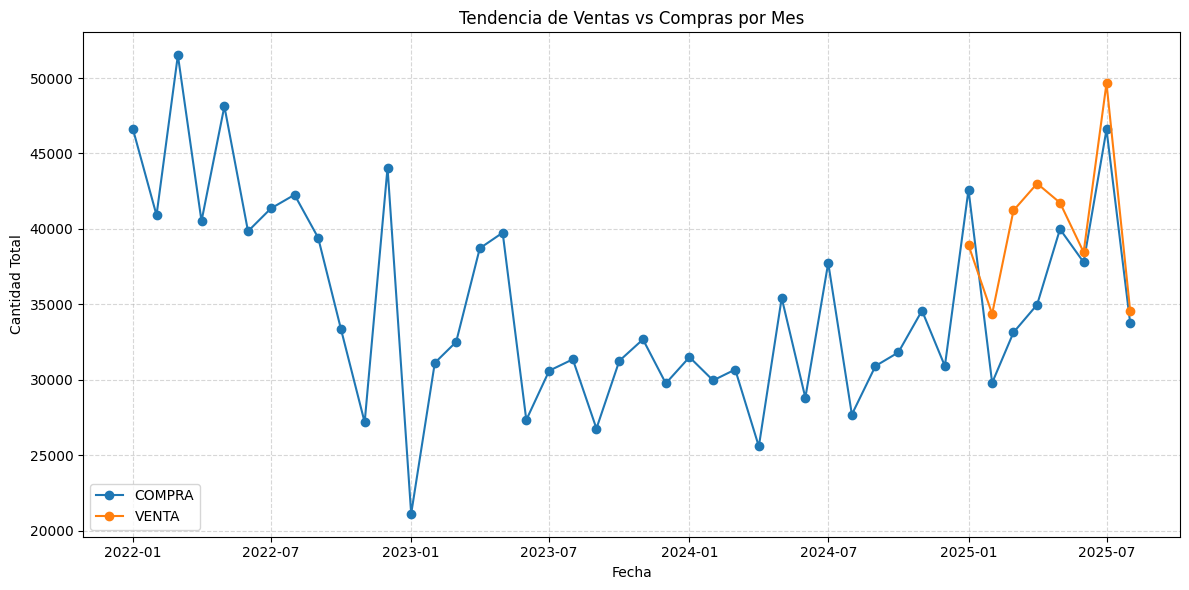

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de tener cargado tu df_unificado
# (si no, carga de nuevo el parquet unificado antes de esto)

# --- AGRUPAR POR MES Y TIPO ---
df_unificado['AÑO_MES'] = df_unificado['FECHA'].dt.to_period('M')  # agrupa por mes
resumen_mensual = (
    df_unificado.groupby(['AÑO_MES', 'TIPO'])['CANTIDAD']
    .sum()
    .reset_index()
)

# Convertir a formato fecha normal para graficar
resumen_mensual['AÑO_MES'] = resumen_mensual['AÑO_MES'].dt.to_timestamp()

# --- GRAFICAR ---
plt.figure(figsize=(12, 6))
for tipo in resumen_mensual['TIPO'].unique():
    datos = resumen_mensual[resumen_mensual['TIPO'] == tipo]
    plt.plot(datos['AÑO_MES'], datos['CANTIDAD'], label=tipo, marker='o')

plt.title('Tendencia de Ventas vs Compras por Mes')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Total')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


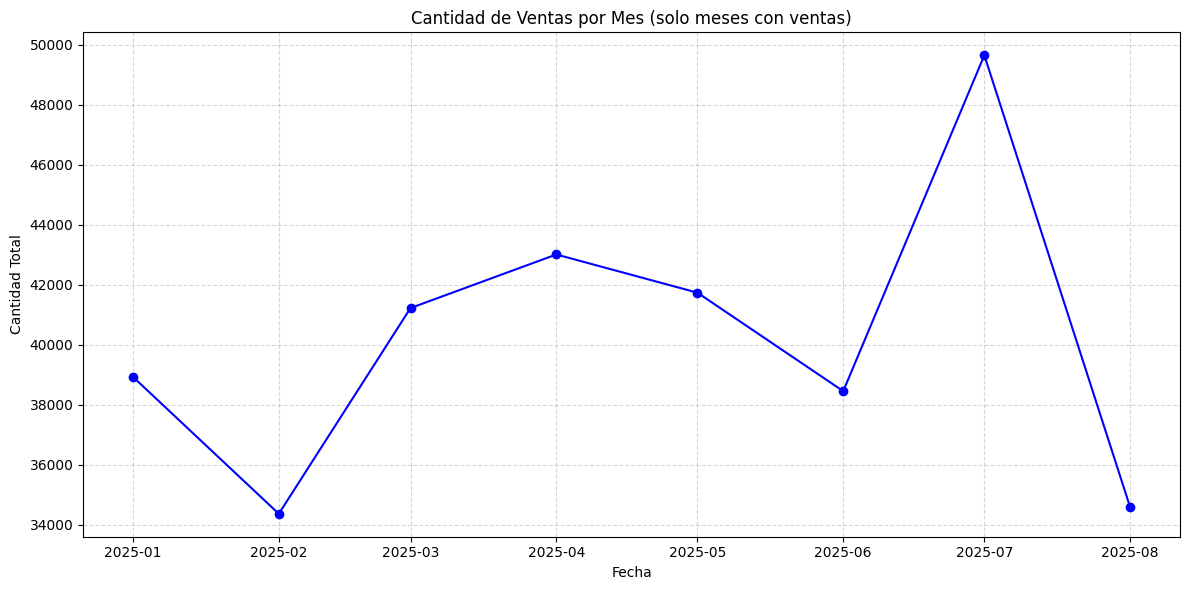

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrar solo las filas donde TIPO sea VENTA
df_venta = df_unificado[df_unificado['TIPO'] == 'VENTA'].copy()

# Agrupar por mes
df_venta['AÑO_MES'] = df_venta['FECHA'].dt.to_period('M')
resumen_venta = (
    df_venta.groupby('AÑO_MES')['CANTIDAD']
    .sum()
    .reset_index()
)

# Convertir a timestamp para graficar
resumen_venta['AÑO_MES'] = resumen_venta['AÑO_MES'].dt.to_timestamp()

# Graficar
plt.figure(figsize=(12,6))
plt.plot(resumen_venta['AÑO_MES'], resumen_venta['CANTIDAD'], marker='o', color='blue')
plt.title('Cantidad de Ventas por Mes (solo meses con ventas)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Total')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [59]:
# Filtrar solo ventas y solo el mes de julio 2025
df_julio = df_unificado[
    (df_unificado['TIPO'] == 'VENTA') &
    (df_unificado['FECHA'].dt.year == 2025) &
    (df_unificado['FECHA'].dt.month == 7)
]

# Agrupar por producto y sumar cantidad
top10_julio = df_julio.groupby('PRODUCTO_BASE')['CANTIDAD'].sum().sort_values(ascending=False).head(10)

# Mostrar resultados
top10_julio



PRODUCTO_BASE
MASTERDOG VETEADO CARNE ARROZ VEG    6609
CACHUPIN                             5967
MASTERDOG VETEADO CACH               2677
CACHUPIN CARNE ARROZ                 2016
BLACK DOG ADULTO  KG                 1905
MASTER CAT SALMON SARDINA JIR        1826
MASTERCAT SALMON SARDINA             1778
DOG BUFFET ADT CARNE                 1595
SABROCAT                             1147
WHISKAS POUCH CARNE                  1137
Name: CANTIDAD, dtype: int64

In [ ]:
# Filtrar solo ventas y solo el mes de julio 2025
df_julio = df_unificado[
    (df_unificado['TIPO'] == 'VENTA') &
    (df_unificado['FECHA'].dt.year == 2025) &
    (df_unificado['FECHA'].dt.month == 7)
]

# Agrupar por producto y comuna, sumar cantidad
top10_julio_comuna = df_julio.groupby(['PRODUCTO_BASE', 'COMUNA'])['CANTIDAD'] \
                             .sum() \
                             .reset_index()

# Ordenar por cantidad descendente y tomar top 10
top10_julio_comuna = top10_julio_comuna.sort_values('CANTIDAD', ascending=False).head(10)

top10_julio_comuna


,PRODUCTO_BASE,COMUNA,CANTIDAD
1364,MASTERDOG VETEADO CARNE ARROZ VEG,OSORNO,1127
1366,MASTERDOG VETEADO CARNE ARROZ VEG,PUERTO MONTT,960
312,CACHUPIN,CASTRO,768
1348,MASTERDOG VETEADO CARNE ARROZ VEG,CASTRO,758
1329,MASTERDOG VETEADO CACH,OSORNO,723
330,CACHUPIN,PUERTO MONTT,650
328,CACHUPIN,OSORNO,634
311,CACHUPIN,CALBUCO,604
308,CACHUPIN,ALERCE (PTO MONTT),587
1495,PED POUCH ADULTO CARNE G,OSORNO,563


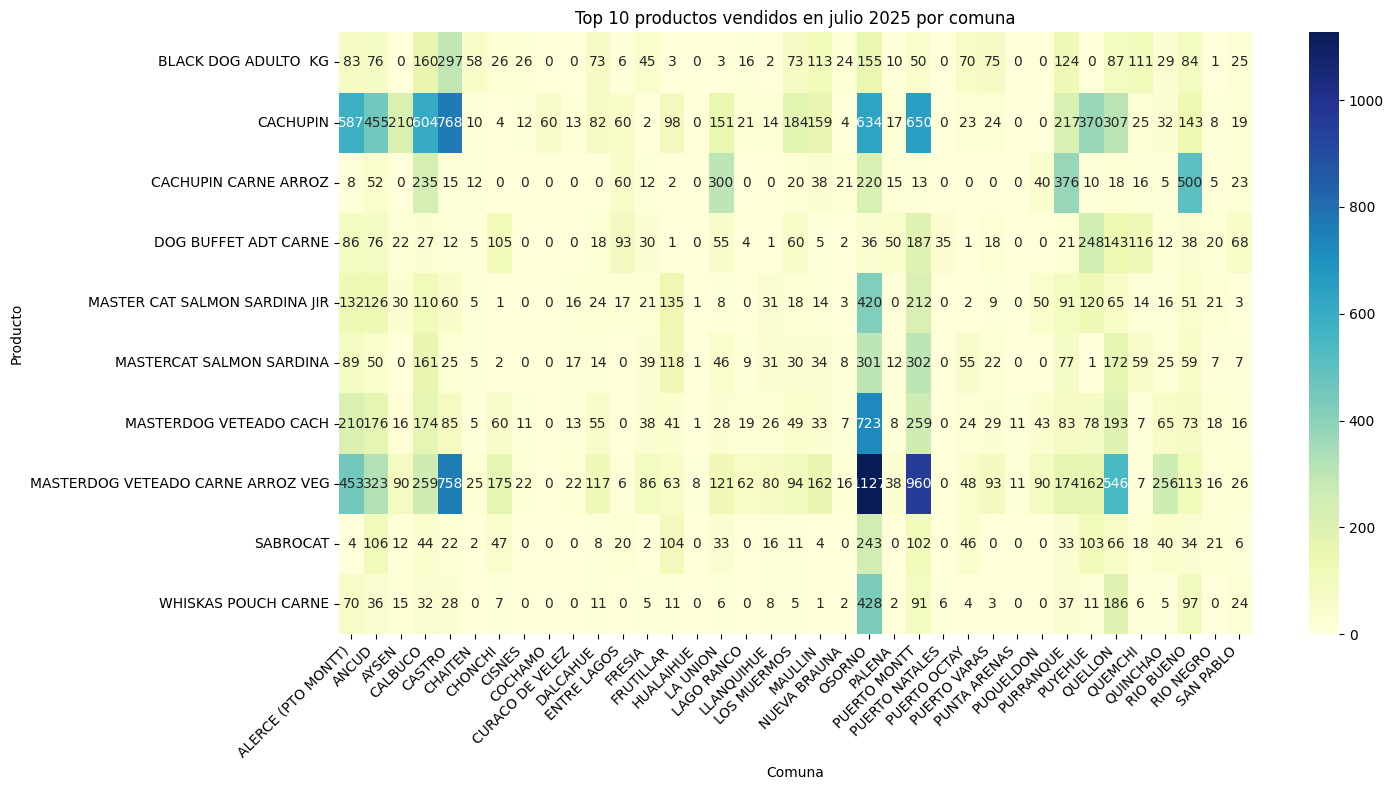

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo ventas de julio 2025
df_julio = df_unificado[
    (df_unificado['TIPO'] == 'VENTA') &
    (df_unificado['FECHA'].dt.to_period('M') == '2025-07')
]

# Top 10 productos más vendidos
top10_productos = df_julio.groupby('PRODUCTO_BASE')['CANTIDAD'].sum().nlargest(10).index

# Filtrar solo los top 10 productos
df_top10 = df_julio[df_julio['PRODUCTO_BASE'].isin(top10_productos)]

# Pivot para heatmap: filas = productos, columnas = comunas
heatmap_data = df_top10.pivot_table(
    index='PRODUCTO_BASE',
    columns='COMUNA',
    values='CANTIDAD',
    aggfunc='sum',
    fill_value=0
)

# Heatmap
plt.figure(figsize=(15,8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Top 10 productos vendidos en julio 2025 por comuna")
plt.ylabel("Producto")
plt.xlabel("Comuna")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


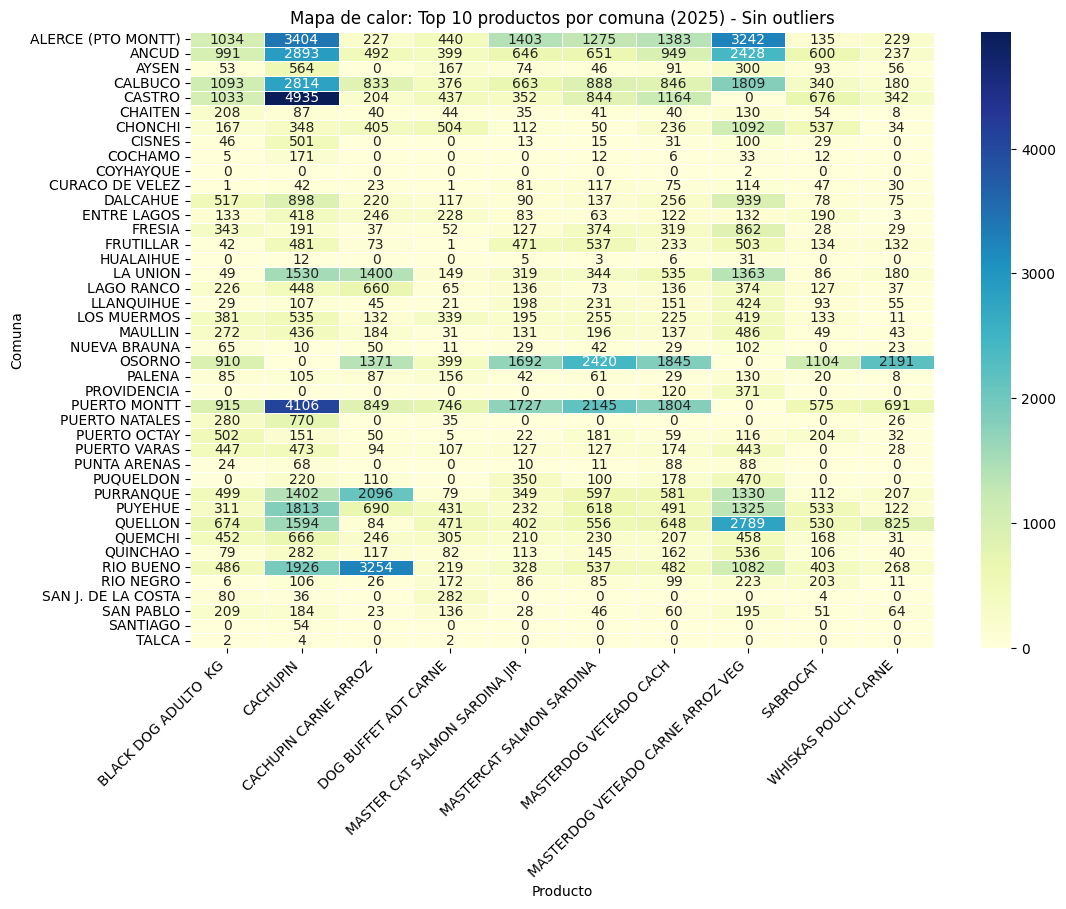

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrar solo ventas del año 2025
df_ventas_2025 = df_unificado[(df_unificado['TIPO'] == 'VENTA') & (df_unificado['FECHA'].dt.year == 2025)]

# Agrupar por producto y obtener los 10 más vendidos
top10_productos = df_ventas_2025.groupby('PRODUCTO_BASE')['CANTIDAD'].sum().nlargest(10).index

# Filtrar solo esos productos
df_top10 = df_ventas_2025[df_ventas_2025['PRODUCTO_BASE'].isin(top10_productos)]

# Agrupar por comuna y producto
ventas_comuna_producto = df_top10.groupby(['COMUNA', 'PRODUCTO_BASE'])['CANTIDAD'].sum().reset_index()

# Eliminar outliers por percentil 99
limite = np.percentile(ventas_comuna_producto['CANTIDAD'], 99)
ventas_comuna_producto = ventas_comuna_producto[ventas_comuna_producto['CANTIDAD'] <= limite]

# Pivotar para matriz de heatmap
pivot = ventas_comuna_producto.pivot(index='COMUNA', columns='PRODUCTO_BASE', values='CANTIDAD').fillna(0)

# Graficar heatmap
plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".0f")
plt.title("Mapa de calor: Top 10 productos por comuna (2025) - Sin outliers")
plt.xlabel("Producto")
plt.ylabel("Comuna")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


In [60]:
import pandas as pd

# Asegurarse de que la columna FECHA esté en formato datetime
df_venta['FECHA'] = pd.to_datetime(df_venta['FECHA'], errors='coerce')

# Crear columna MES
df_venta['MES'] = df_venta['FECHA'].dt.month

# Obtener los meses únicos ordenados
meses_con_venta = sorted(df_venta['MES'].dropna().unique())

print("Meses con ventas registradas:", meses_con_venta)


Meses con ventas registradas: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8)]


In [69]:
import pandas as pd

# --------------------------------------------------------
# 🧾 Cargar datasets normalizados (Parquet)
# --------------------------------------------------------
df_compra = pd.read_parquet(
    r"C:/Users/raulr/OneDrive/Escritorio/ProyectoAllendesKedro/analisis/data/03_primary/matriz_compra_normalizada.parquet",
    engine="pyarrow"
)
df_venta = pd.read_parquet(
    r"C:/Users/raulr/OneDrive/Escritorio/ProyectoAllendesKedro/analisis/data/03_primary/matriz_venta_normalizada.parquet",
    engine="pyarrow"
)

# --------------------------------------------------------
# 📆 Asegurar que la columna FECHA sea datetime
# --------------------------------------------------------
df_compra['FECHA'] = pd.to_datetime(df_compra['FECHA'], errors='coerce')
df_venta['FECHA'] = pd.to_datetime(df_venta['FECHA'], errors='coerce')

# --------------------------------------------------------
# 📆 Filtrar solo el año 2025
# --------------------------------------------------------
df_compra_2025 = df_compra[df_compra['FECHA'].dt.year == 2025].copy()
df_venta_2025 = df_venta[df_venta['FECHA'].dt.year == 2025].copy()

# --------------------------------------------------------
# 📊 Obtener meses únicos de cada dataset
# --------------------------------------------------------
meses_compra = sorted(df_compra_2025['FECHA'].dt.month.unique())
meses_venta = sorted(df_venta_2025['FECHA'].dt.month.unique())

# Intersección de meses comunes (hasta 8)
meses_comunes = sorted(list(set(meses_compra).intersection(meses_venta)))[:8]

# --------------------------------------------------------
# 🔄 Filtrar ambos datasets por los meses comunes
# --------------------------------------------------------
df_compra_filtrado = df_compra_2025[df_compra_2025['FECHA'].dt.month.isin(meses_comunes)]
df_venta_filtrado = df_venta_2025[df_venta_2025['FECHA'].dt.month.isin(meses_comunes)]

# --------------------------------------------------------
# ✅ Mostrar resumen de los datasets filtrados
# --------------------------------------------------------
print("Meses seleccionados:", meses_comunes)
print(f"Compras filtradas: {len(df_compra_filtrado)} registros")
print(f"Ventas filtradas: {len(df_venta_filtrado)} registros")

print("\n===== DF COMPRA FILTRADO =====")
print(df_compra_filtrado.head())

print("\n===== DF VENTA FILTRADO =====")
print(df_venta_filtrado.head())


Meses seleccionados: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8)]
Compras filtradas: 2308 registros
Ventas filtradas: 76047 registros

===== DF COMPRA FILTRADO =====
    TIP_DOC COD_PROD                            PRODUCTO  CANTIDAD     COMUNA  \
888     FCC    80228  ARENA HAPPY AGLUT LAVANDA 8 X 2 KG       162  QUILICURA   
889     FCC    80229    ARENA HAPPY AGLUT LIMON 8 X 2 KG        54  QUILICURA   
890     FCC    80281    ARENA AGLUT HAPPY CARBON X 10 KG        20  QUILICURA   
891     FCC    80230    ARENA HAPPY AGLUT ROSAS 8 X 2 KG        54  QUILICURA   
892     FCC    80231     ARENA HAPPY AGLUT CAFE 8 X 2 KG       108  QUILICURA   

         FECHA  PESO_KG              PRODUCTO_BASE  
888 2025-01-14      2.0  ARENA HAPPY AGLUT LAVANDA  
889 2025-01-14      2.0    ARENA HAPPY AGLUT LIMON  
890 2025-01-14     10.0   ARENA AGLUT HAPPY CARBON  
891 2025-01-28      2.0    ARENA HAPPY AGLUT ROSAS  
892 2025-01-28      2.

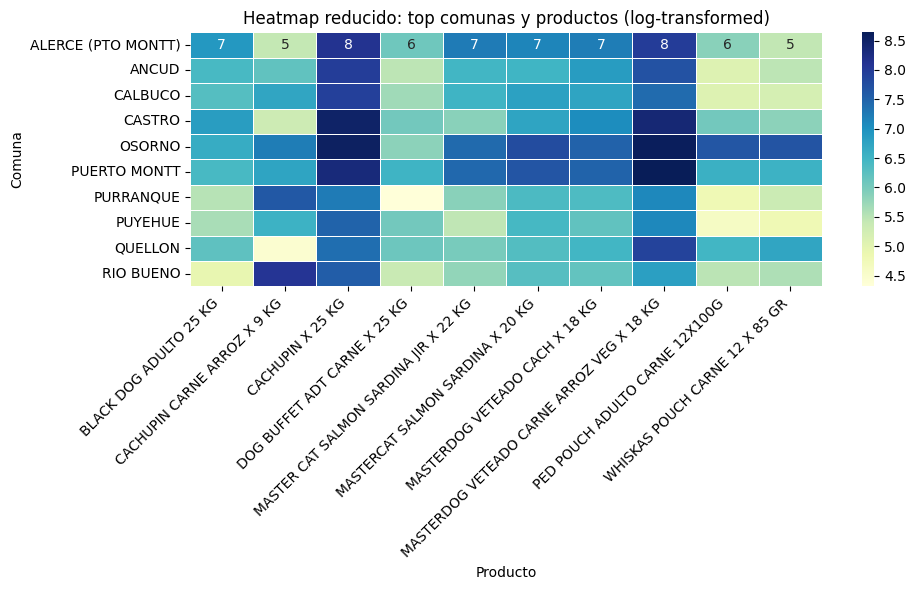

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def heatmap_top10_consola(df: pd.DataFrame) -> None:
    """
    Muestra en pantalla un heatmap reducido de los 10 productos más vendidos en 2025
    para las top 10 comunas, usando log-transform para mejor visualización.
    """

    # Filtrar solo ventas 2025
    df_ventas_2025 = df[df['FECHA'].dt.year == 2025]

    # Top 10 productos
    top10_productos = df_ventas_2025.groupby('PRODUCTO')['CANTIDAD'].sum().nlargest(10).index
    df_top10 = df_ventas_2025[df_ventas_2025['PRODUCTO'].isin(top10_productos)]

    # Top 10 comunas
    top_comunas = df_top10.groupby('COMUNA')['CANTIDAD'].sum().nlargest(10).index
    df_top10_reducido = df_top10[df_top10['COMUNA'].isin(top_comunas)]

    # Pivot_table con agregación para evitar duplicados
    pivot = df_top10_reducido.pivot_table(
        index='COMUNA',
        columns='PRODUCTO',
        values='CANTIDAD',
        aggfunc='sum',  # suma si hay duplicados
        fill_value=0
    )

    # Aplicar log-transform
    pivot_log = np.log1p(pivot)

    # Graficar
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot_log, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".0f")
    plt.title("Heatmap reducido: top comunas y productos (log-transformed)")
    plt.xlabel("Producto")
    plt.ylabel("Comuna")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Llamar a la función
heatmap_top10_consola(df_venta_filtrado)


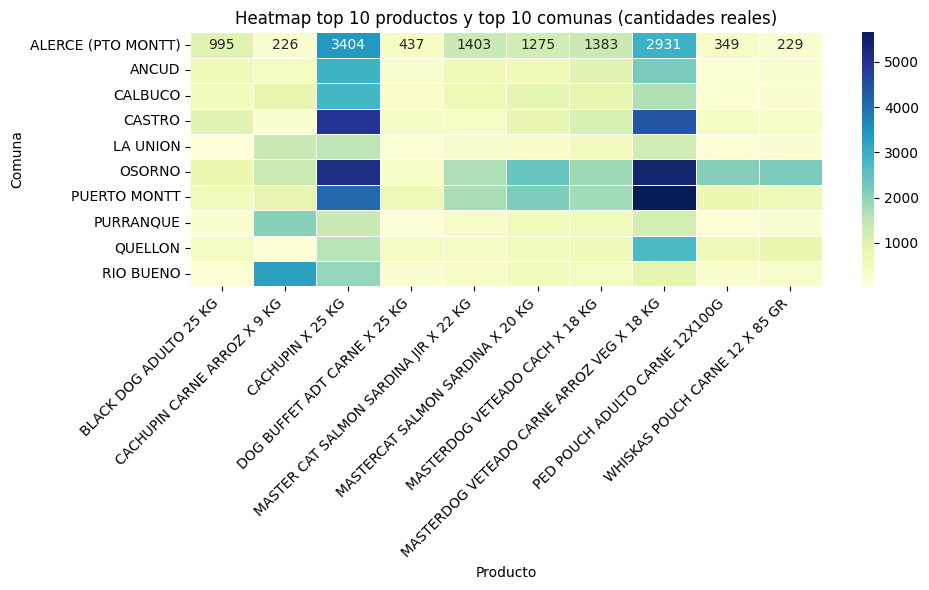

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def heatmap_top10_consola(df: pd.DataFrame) -> None:
    """
    Muestra en pantalla un heatmap de los 10 productos más vendidos en 2025
    para las top 10 comunas, mostrando cantidades reales.
    """

    # Filtrar solo ventas 2025
    df_2025 = df[df['FECHA'].dt.year == 2025]

    # Top 10 productos
    top10_productos = df_2025.groupby('PRODUCTO')['CANTIDAD'].sum().nlargest(10).index

    # Top 10 comunas
    top10_comunas = df_2025.groupby('COMUNA')['CANTIDAD'].sum().nlargest(10).index

    # Filtrar DataFrame
    df_reducido = df_2025[
        (df_2025['PRODUCTO'].isin(top10_productos)) &
        (df_2025['COMUNA'].isin(top10_comunas))
    ]

    # Pivot con suma para evitar duplicados
    pivot = df_reducido.pivot_table(
        index='COMUNA',
        columns='PRODUCTO',
        values='CANTIDAD',
        aggfunc='sum',
        fill_value=0
    )

    # Graficar
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".0f")
    plt.title("Heatmap top 10 productos y top 10 comunas (cantidades reales)")
    plt.xlabel("Producto")
    plt.ylabel("Comuna")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Llamar a la función
heatmap_top10_consola(df_venta_filtrado)


In [82]:
import pandas as pd

# Filtrar solo ventas 2025
df_2025 = df_venta_filtrado[df_venta_filtrado['FECHA'].dt.year == 2025]

# Top 10 productos
top10_productos = df_2025.groupby('PRODUCTO')['CANTIDAD'].sum().nlargest(10).index

# Top 10 comunas
top10_comunas = df_2025.groupby('COMUNA')['CANTIDAD'].sum().nlargest(10).index

# Filtrar DataFrame
df_reducido = df_2025[
    (df_2025['PRODUCTO'].isin(top10_productos)) &
    (df_2025['COMUNA'].isin(top10_comunas))
]

# Pivot para ver la matriz de cantidades
pivot = df_reducido.pivot_table(
    index='COMUNA',
    columns='PRODUCTO',
    values='CANTIDAD',
    aggfunc='sum',
    fill_value=0
)

# Guardar a Excel
output_path = r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\top10_ventas.xlsx"
pivot.to_excel(output_path)

print(f"Archivo Excel creado en: {output_path}")


Archivo Excel creado en: C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\top10_ventas.xlsx


In [85]:
# %% Librerías
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# %% Funciones
def preparar_features(df):
    """
    Crea features numéricas a partir de columnas categóricas
    y devuelve X (features) y y (target).
    """
    df = df.copy()
    df['MES'] = df['FECHA'].dt.month
    df['PRODUCTO_ID'] = df['PRODUCTO'].astype('category').cat.codes
    df['COMUNA_ID'] = df['COMUNA'].astype('category').cat.codes

    X = df[['MES', 'PRODUCTO_ID', 'COMUNA_ID']]
    y = df['CANTIDAD']
    return X, y

def entrenar_modelos(X, y):
    """
    Entrena ≥5 modelos de regresión y devuelve un diccionario de modelos.
    """
    modelos = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.1),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
        "SVR": SVR()
    }

    for nombre, modelo in modelos.items():
        modelo.fit(X, y)

    return modelos

def evaluar_modelos(modelos_regresion, X, y):
    """
    Evalúa los modelos sobre X e y, devolviendo métricas.
    """
    metricas = {}
    for nombre, modelo in modelos_regresion.items():
        y_pred = modelo.predict(X)
        metricas[nombre] = {
            "RMSE": mean_squared_error(y, y_pred, squared=False),
            "MAE": mean_absolute_error(y, y_pred),
            "R2": r2_score(y, y_pred)
        }
    return metricas

# %% Cargar datos
# Asegúrate de tener df_venta_filtrado disponible
# df_venta_filtrado = pd.read_parquet("ruta_a_tu_parquet_filtrado.parquet")

# %% Preparar features
X_reg, y_reg = preparar_features(df_venta_filtrado)

print("Shape X_reg:", X_reg.shape)
print("Shape y_reg:", y_reg.shape)

# %% Entrenar modelos
modelos_regresion = entrenar_modelos(X_reg, y_reg)

# %% Evaluar modelos
metricas_regresion = evaluar_modelos(modelos_regresion, X_reg, y_reg)

# %% Mostrar métricas
metricas_df = pd.DataFrame(metricas_regresion).T
print(metricas_df)

# %% Guardar métricas a Excel
metricas_df.to_excel("metricas_regresion.xlsx", index=True)
print("Métricas guardadas en metricas_regresion.xlsx")


Shape X_reg: (76047, 3)
Shape y_reg: (76047,)


[10/24/25 00:47:08] WARNING  c:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\.ven warnings.py:110
                             v\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:                
                             'squared' is deprecated in version 1.4 and will be removed in 1.6. To                 
                             calculate the root mean squared error, use the                                        
                             function'root_mean_squared_error'.                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  c:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\.ven warnings.py:110
                             v\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:                
                             'squared' is deprecated in version 1.4 and will be removed in 1.6. To                 
                             calculate the root mean squared error, use the                                        
                             function'root_mean_squared_error'.                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  c:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\.ven warnings.py:110
                             v\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:                
                             'squared' is deprecated in version 1.4 and will be removed in 1.6. To                 
                             calculate the root mean squared error, use the                                        
                             function'root_mean_squared_error'.                                                    
                               warnings.warn(                                                                      
                                                                                                                   

[10/24/25 00:47:10] WARNING  c:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\.ven warnings.py:110
                             v\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:                
                             'squared' is deprecated in version 1.4 and will be removed in 1.6. To                 
                             calculate the root mean squared error, use the                                        
                             function'root_mean_squared_error'.                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  c:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\.ven warnings.py:110
                             v\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:                
                             'squared' is deprecated in version 1.4 and will be removed in 1.6. To                 
                             calculate the root mean squared error, use the                                        
                             function'root_mean_squared_error'.                                                    
                               warnings.warn(                                                                      
                                                                                                                   

[10/24/25 00:55:47] WARNING  c:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\.ven warnings.py:110
                             v\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:                
                             'squared' is deprecated in version 1.4 and will be removed in 1.6. To                 
                             calculate the root mean squared error, use the                                        
                             function'root_mean_squared_error'.                                                    
                               warnings.warn(                                                                      
                                                                                                                   

                       RMSE       MAE        R2
LinearRegression  13.042457  4.771467  0.005206
Ridge             13.042457  4.771467  0.005206
Lasso             13.042535  4.770889  0.005194
RandomForest      11.083099  3.433348  0.281649
GradientBoosting  12.490255  4.339639  0.087659
SVR               13.446697  3.257164 -0.057416
Métricas guardadas en metricas_regresion.xlsx


In [ ]:
# %% Librerías
import pandas as pd
import numpy as np

# %% Función de preprocesamiento de ventas
def preprocesar_ventas(df):
    df = df.copy()
    
    # --- Features básicas ---
    df['MES'] = df['FECHA'].dt.month
    df['PRODUCTO_ID'] = df['PRODUCTO'].astype('category').cat.codes
    df['COMUNA_ID'] = df['COMUNA'].astype('category').cat.codes
    
    # --- Filtrado por percentiles para eliminar outliers ---
    q_low = df['CANTIDAD'].quantile(0.01)   # 1er percentil
    q_high = df['CANTIDAD'].quantile(0.99)  # 99º percentil
    df = df[(df['CANTIDAD'] >= q_low) & (df['CANTIDAD'] <= q_high)]
    
    # --- Ordenar para calcular ventas anteriores ---
    df = df.sort_values(['PRODUCTO_ID','COMUNA_ID','FECHA'])
    
    # --- Feature histórica para clasificación binaria ---
    df['VENTA_MES_ANTERIOR'] = df.groupby(['PRODUCTO_ID','COMUNA_ID'])['CANTIDAD'].shift(1)
    df = df.dropna(subset=['VENTA_MES_ANTERIOR'])
    df['AUMENTA'] = (df['CANTIDAD'] > df['VENTA_MES_ANTERIOR']).astype(int)
    
    # --- Clasificación multiclase usando percentiles ---
    percentiles = [0, 0.33, 0.66, 1.0]
    bins = df['CANTIDAD'].quantile(percentiles).values
    bins = np.unique(bins)  # Evitar duplicados
    
    if len(bins) > 1:
        etiquetas = ['baja','media','alta'][:len(bins)-1]
        df['VENTA_CLASE'] = pd.cut(df['CANTIDAD'], bins=bins, labels=etiquetas, include_lowest=True)
    else:
        df['VENTA_CLASE'] = 'media'
    
    # --- Selección final de columnas ---
    columnas_finales = [
        'FECHA','PRODUCTO','COMUNA','CANTIDAD','MES','PRODUCTO_ID','COMUNA_ID',
        'VENTA_MES_ANTERIOR','AUMENTA','VENTA_CLASE'
    ]
    
    df = df[columnas_finales]
    
    return df

# %% Ejemplo de uso en Jupyter
ruta_venta = r"C:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\data\03_primary\df_venta_8meses.parquet"
df_venta_8meses = pd.read_parquet(ruta_venta)

df_ventas_procesadas = preprocesar_ventas(df_venta_8meses)

print("=== Ventas Procesadas ===")
print(df_ventas_procesadas.head())


=== Ventas Procesadas ===
           FECHA                        PRODUCTO              COMUNA  \
13945 2025-02-27  ALIMENTO CONEJO RABITO X 20 KG  ALERCE (PTO MONTT)   
26493 2025-04-10  ALIMENTO CONEJO RABITO X 20 KG  ALERCE (PTO MONTT)   
12091 2025-02-10  ALIMENTO CONEJO RABITO X 20 KG               ANCUD   
6120  2025-02-17  ALIMENTO CONEJO RABITO X 20 KG               ANCUD   
18184 2025-03-04  ALIMENTO CONEJO RABITO X 20 KG               ANCUD   

       CANTIDAD  MES  PRODUCTO_ID  COMUNA_ID  VENTA_MES_ANTERIOR  AUMENTA  \
13945         2    2            0          0                 3.0        0   
26493         1    4            0          0                 2.0        0   
12091         5    2            0          1                 5.0        0   
6120         10    2            0          1                 5.0        1   
18184         5    3            0          1                10.0        0   

      VENTA_CLASE  
13945        baja  
26493        baja  
12091       media 

In [5]:
# %% Librerías
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# %% Preparar features históricas para regresión
def preparar_features_historicas(df):
    df = df.copy()
    df['MES'] = df['FECHA'].dt.month
    df['PRODUCTO_ID'] = df['PRODUCTO'].astype('category').cat.codes
    df['COMUNA_ID'] = df['COMUNA'].astype('category').cat.codes

    # Ordenar y crear features históricos
    df.sort_values(['PRODUCTO_ID','COMUNA_ID','MES'], inplace=True)
    grp = df.groupby(['PRODUCTO_ID','COMUNA_ID'])['CANTIDAD']
    
    df['VENTA_MES_ANTERIOR'] = grp.shift(1)
    df['PROM_3_MESES'] = grp.shift(1).rolling(3, min_periods=1).mean()
    df['PROM_6_MESES'] = grp.shift(1).rolling(6, min_periods=1).mean()
    df['DELTA_MES'] = (df['CANTIDAD'] - df['VENTA_MES_ANTERIOR']) / df['VENTA_MES_ANTERIOR']

    # Eliminar filas sin histórico
    df = df.dropna(subset=['VENTA_MES_ANTERIOR'])

    # Features y target
    X = df[['MES','PRODUCTO_ID','COMUNA_ID','VENTA_MES_ANTERIOR','PROM_3_MESES','PROM_6_MESES','DELTA_MES']]
    y = df['CANTIDAD']
    return X, y

# %% Entrenar modelos de regresión (rápido)
def entrenar_modelos_regresion(X_train, y_train):
    modelos = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.1),
        "RandomForest": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=50, random_state=42),
        "SVR_linear": SVR(kernel='linear', C=1.0)  # más rápido que RBF
    }
    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
    return modelos

# %% Evaluar modelos
def evaluar_modelos_regresion(modelos, X, y):
    metricas = {}
    for nombre, modelo in modelos.items():
        y_pred = modelo.predict(X)
        metricas[nombre] = {
            "RMSE": mean_squared_error(y, y_pred, squared=False),
            "MAE": mean_absolute_error(y, y_pred),
            "R2": r2_score(y, y_pred)
        }
    return metricas

# %% Pipeline completo
X, y = preparar_features_historicas(df_ventas_procesadas)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento
modelos_regresion = entrenar_modelos_regresion(X_train, y_train)

# Evaluación
metricas_train = evaluar_modelos_regresion(modelos_regresion, X_train, y_train)
metricas_test  = evaluar_modelos_regresion(modelos_regresion, X_test, y_test)

# %% Mostrar resultados
metricas_df_train = pd.DataFrame(metricas_train).T
metricas_df_test  = pd.DataFrame(metricas_test).T

print("=== Métricas Train ===")
print(metricas_df_train)
print("\n=== Métricas Test ===")
print(metricas_df_test)


c:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\.ven

=== Métricas Train ===
                      RMSE       MAE        R2
LinearRegression  3.553752  1.309095  0.647537
Ridge             3.553752  1.309095  0.647537
Lasso             3.554151  1.309922  0.647458
RandomForest      0.090562  0.006666  0.999771
GradientBoosting  0.696426  0.260765  0.986464
SVR_linear        4.910337  3.440910  0.327083

=== Métricas Test ===
                      RMSE       MAE        R2
LinearRegression  3.636800  1.348560  0.662434
Ridge             3.636800  1.348559  0.662434
Lasso             3.637195  1.349129  0.662361
RandomForest      0.201194  0.016599  0.998967
GradientBoosting  0.732663  0.266573  0.986300
SVR_linear        5.009066  3.479359  0.359626


c:\Users\raulr\OneDrive\Escritorio\ProyectoAllendesKedro\analisis\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Análisis de Clustering con K-Means y Visualización PCA

En esta sección realizamos un análisis de *aprendizaje no supervisado* utilizando el algoritmo **K-Means** con el objetivo de identificar patrones y grupos naturales dentro de los datos.

### 1. Normalización de Datos
Primero se estandarizaron las variables numéricas mediante `StandardScaler`.  
Esto asegura que todas las características estén en la misma escala, evitando que aquellas con valores más grandes dominen la distancia usada por el modelo.

### 2. Reducción de Dimensionalidad (PCA)
Luego aplicamos **PCA (Análisis de Componentes Principales)** para reducir la dimensionalidad del dataset a solo 2 componentes.  
Esto nos permite **visualizar** la estructura de los datos en un plano 2D sin perder demasiada información.

### 3. Agrupamiento con K-Means
Se utilizó K-Means para agrupar los registros en **k clusters**.  
Este algoritmo asigna cada punto al grupo cuyo centroide está más cercano en términos de distancia euclidiana.

### 4. Visualización
Finalmente, se generó un gráfico de dispersión donde:
- Cada punto representa un registro.
- El color indica el cluster al cual pertenece.
- La separación visual entre grupos refleja similitud o diferencia entre registros.

Este análisis es útil para:
- Identificar segmentos o patrones ocultos.
- Apoyar decisiones sobre estrategias diferenciadas.
- Entender la estructura interna del dataset.


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
from sklearn.cluster import KMeans

# Cargar dataset procesado
X_procesada_rg = pd.read_csv(r"C:\Users\raulr\ProyectoAllendesKedro\ProyectoAllendesKedro\analisis\data\05_model_input\X_procesada_rg.csv")

print("Dataset cargado correctamente:", X_procesada_rg.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_procesada_rg)

print("Escalado finalizado:", X_scaled.shape)


kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

print("Clustering finalizado.")


# Calcular calidad del clustering
sil_score = silhouette_score(X_scaled, kmeans.labels_)

# Crear tabla resumen de clusters
cluster_summary = X_procesada_rg.copy()
cluster_summary["Cluster"] = kmeans.labels_
cluster_means = cluster_summary.groupby("Cluster").mean()

print("=== Calidad del Clustering ===")
print(f"Silhouette Score: {sil_score:.3f}")

print("\nInterpretación Automática:")
if sil_score > 0.6:
    print("→ Los clusters están bien definidos y claramente separados ✅")
elif sil_score > 0.4:
    print("→ Separación aceptable, pero podría mejorarse ⚠️")
else:
    print("→ Los clusters no están bien diferenciados. Considera ajustar k o incluir menos ruido ❌")

print("\n=== Promedio de variables por cluster ===")
display(cluster_means)

print("\nInterpretación general:")
print("Cada cluster representa un grupo con patrones similares. "
      "Los promedios permiten identificar qué caracteriza cada cluster y tomar decisiones basadas en comportamientos reales.")


Dataset cargado correctamente: (71106, 7)
Escalado finalizado: (71106, 7)
Clustering finalizado.
=== Calidad del Clustering ===
Silhouette Score: 0.236

Interpretación Automática:
→ Los clusters no están bien diferenciados. Considera ajustar k o incluir menos ruido ❌

=== Promedio de variables por cluster ===


,MES,PRODUCTO_ID,COMUNA_ID,VENTA_MES_ANTERIOR,PROM_3_MESES,PROM_6_MESES,DELTA_MES
Cluster,,,,,,,
0,4.827044,246.277801,27.138626,2.632222,2.978699,3.289909,1.409046
1,4.625978,227.085334,3.546831,3.191058,3.439356,3.735635,1.290847
2,4.534125,182.505045,21.099110,61.299703,48.673986,35.901672,0.892509



Interpretación general:
Cada cluster representa un grupo con patrones similares. Los promedios permiten identificar qué caracteriza cada cluster y tomar decisiones basadas en comportamientos reales.


Cluster 0	Ventas bajas y estables	Promedios bajos en todas las ventas. Productos con poca variación. Clientes/territorios de demanda estable baja.
Cluster 1	Ventas muy bajas y volátiles	Son productos o zonas con ventas casi nulas y fluctuación constante → riesgo de discontinuación.
Cluster 2	Ventas altas con picos fuertes	PROM_3_MESES y PROM_6_MESES son muy altas, lo que indica demanda fuerte y estacional o campañas activas.
Interpretación Estratégica (para negocio)

Cluster 2: Productos / zonas prioritarios → mantener stock, optimizar reposición, proteger oferta.

Cluster 0: Productos con demanda moderada y constante → mantener stock estándar.

Cluster 1: Productos de baja rotación → revisar si deben:

Reducirse

Sustituirse

Promocionarse

In [8]:
import pandas as pd

# Cargar métricas desde archivo
metricas_clf = pd.read_csv(
    r"C:\Users\raulr\ProyectoAllendesKedro\ProyectoAllendesKedro\analisis\data\08_reporting\metricas_test_clf.csv",
    index_col=0
)

print("=== Resultados de Modelos de Clasificación ===")
display(metricas_clf)

print("\n=== Interpretación de Métricas ===")
print("""
Accuracy   → Porcentaje de predicciones correctas.
Precision  → Qué tan correctas son las predicciones positivas.
Recall     → Qué tan bien el modelo detecta los casos positivos reales.
F1 Score   → Promedio armónico entre Precision y Recall.
""")

# Interpretación automática modelo por modelo
for modelo, fila in metricas_clf.iterrows():
    f1 = fila["F1"]
    print(f"\n🔹 Modelo: {modelo}")
    if f1 > 0.80:
        print("→ Excelente desempeño ✅")
    elif f1 > 0.60:
        print("→ Desempeño aceptable ⚖️ (se puede optimizar)")
    else:
        print("→ Desempeño bajo ❌ Puede requerir más features, limpieza o ajuste")


=== Resultados de Modelos de Clasificación ===


,Precision,Recall,F1
Accuracy,,,
0.961062,0.955361,0.961062,0.955957
0.991562,0.991480,0.991562,0.991496
0.992529,0.992453,0.992529,0.992478
0.965369,0.962594,0.965369,0.958926
0.965808,0.962051,0.965808,0.962759



=== Interpretación de Métricas ===

Accuracy   → Porcentaje de predicciones correctas.
Precision  → Qué tan correctas son las predicciones positivas.
Recall     → Qué tan bien el modelo detecta los casos positivos reales.
F1 Score   → Promedio armónico entre Precision y Recall.


🔹 Modelo: 0.961061791333392
→ Excelente desempeño ✅

🔹 Modelo: 0.9915619231783422
→ Excelente desempeño ✅

🔹 Modelo: 0.9925287861474904
→ Excelente desempeño ✅

🔹 Modelo: 0.9653687263777796
→ Excelente desempeño ✅

🔹 Modelo: 0.9658082095455744
→ Excelente desempeño ✅


In [11]:
import pandas as pd

# Cargar datasets usados para clasificación
X_clf = pd.read_csv(
    r"C:\Users\raulr\ProyectoAllendesKedro\ProyectoAllendesKedro\analisis\data\05_model_input\X_procesada_clf.csv"
)
y_clf = pd.read_csv(
    r"C:\Users\raulr\ProyectoAllendesKedro\ProyectoAllendesKedro\analisis\data\05_model_input\y_procesada_clf.csv"
)

print("=== Clasificación: Variables Utilizadas ===")
print(f"Variable Predictora (y): {y_clf.columns[0]}")
print(f"Cantidad de variables explicativas (X): {len(X_clf.columns)}")
print("\nLista de Variables Explicativas:")
for col in X_clf.columns:
    print(f" - {col}")


=== Clasificación: Variables Utilizadas ===
Variable Predictora (y): VENTA_CLASE
Cantidad de variables explicativas (X): 7

Lista de Variables Explicativas:
 - MES
 - PRODUCTO_ID
 - COMUNA_ID
 - VENTA_MES_ANTERIOR
 - PROM_3_MESES
 - PROM_6_MESES
 - DELTA_MES


Métrica Final: Todas por sobre 0.96 → Excelente desempeño

Variable a predecir (y): VENTA_CLASE (clasificación de ventas, ej. alta / media / baja)

Variables explicativas (X):
MES, PRODUCTO_ID, COMUNA_ID, VENTA_MES_ANTERIOR, PROM_3_MESES, PROM_6_MESES, DELTA_MES

✅ Conclusión Técnica del Modelo

El modelo presenta métricas sobresalientes:

Métrica	            Interpretación	                                Resultado	Evaluación
Accuracy	% total de predicciones correctas	                    ~0.96–0.99	Excelente
Precision	Qué tan correctas son las predicciones positivas	    Muy alta	Excelente
Recall	Capacidad para encontrar correctamente los casos reales	    Muy alta	Excelente
F1 Score	Equilibrio entre Precision y Recall	                    Muy alta	Óptimo

Interpretación:
El modelo no solo es preciso, sino que también detecta correctamente las clases reales sin sobreajustarse, mostrando un comportamiento balanceado y robusto.

✅ Conclusión sobre las Variables (Importancia Conceptual)

El modelo utiliza variables históricas y contextuales que hacen sentido desde el punto de vista comercial:

Variable	                    Significado	Aporte
VENTA_MES_ANTERIOR	            Nivel de ventas reciente	Alta capacidad de predicción — el pasado influye directamente.
PROM_3_MESES / PROM_6_MESES	    Tendencia de ventas a corto y mediano plazo	Permiten leer ciclos, capturan demanda recurrente.
DELTA_MES	                    Cambio respecto al mes anterior	Detecta crecimientos o caídas.
MES	                            Estacionalidad	Captura patrones mensuales (ej: más ventas fin de año).
PRODUCTO_ID	                    Diferencias por línea de producto	Hay productos que se venden más naturalmente.
COMUNA_ID	                    Demanda territorial	Algunas zonas tienen mayor consumo que otras.

Conclusión:
El modelo está aprendiendo patrones reales del negocio: tendencias, estacionalidad y comportamiento geográfico.
Esto confirma que el modelo tiene coherencia comercial y no está prediciendo por azar.

✅ Conclusión de Negocio (Explicación para presentar)

El modelo permite clasificar el nivel de venta de un producto en una comuna en un mes, utilizando información histórica y variables contextuales.
Dado su alto desempeño, este modelo es apto para apoyar decisiones operacionales, tales como:

Planificación de compras

Optimización de inventario

Definición de precios y promociones por zona

Prevención de quiebre de stock

Impacto esperado:

Menores pérdidas por sobrestock

Menor probabilidad de quiebre de inventario

Mejor asignación de productos según demanda real

Conclusión Final Redactada 

El modelo de clasificación desarrollado para predecir la variable VENTA_CLASE presenta un desempeño excelente, con métricas superiores a 0.96 en Accuracy, Precision, Recall y F1 Score. Esto indica que el modelo es altamente confiable tanto para identificar correctamente las categorías de venta como para evitar errores de clasificación.

Las variables utilizadas se basan en antecedentes históricos de ventas, tendencias de corto y mediano plazo, estacionalidad y características territoriales, lo que permite capturar patrones reales del comportamiento comercial.

Gracias a su alto rendimiento y coherencia con la lógica del negocio, este modelo es adecuado para apoyar decisiones estratégicas y operacionales relacionadas con la planificación de inventario, compras y asignación de stock por producto y comuna.

In [9]:
# Cargar métricas de regresión
metricas_reg = pd.read_csv(
    r"C:\Users\raulr\ProyectoAllendesKedro\ProyectoAllendesKedro\analisis\data\08_reporting\metricas_test.csv",
    index_col=0
)

print("=== Resultados Modelos de Regresión ===")
display(metricas_reg)

print("""
RMSE → Mientras más bajo, mejor. Error promedio.
MAE  → Error absoluto promedio.
R2   → Capacidad explicativa. 1 = perfecto, 0 = no explica nada.
""")

for modelo, fila in metricas_reg.iterrows():
    r2 = fila["R2"]
    print(f"\n🔹 Modelo: {modelo}")
    if r2 > 0.75:
        print("→ Resultados excelentes ✅")
    elif r2 > 0.50:
        print("→ Resultados razonables ⚖️ (puede mejorar)")
    else:
        print("→ Modelo débil ❌ Requiere ajuste o nuevas variables")


=== Resultados Modelos de Regresión ===


,MAE,R2
RMSE,,
9.584817,2.533574,0.528588
9.584819,2.533572,0.528588
9.585396,2.530447,0.528531
2.576003,0.104272,0.965949
2.399392,0.390366,0.970458



RMSE → Mientras más bajo, mejor. Error promedio.
MAE  → Error absoluto promedio.
R2   → Capacidad explicativa. 1 = perfecto, 0 = no explica nada.


🔹 Modelo: 9.584817119974629
→ Resultados razonables ⚖️ (puede mejorar)

🔹 Modelo: 9.584818792851722
→ Resultados razonables ⚖️ (puede mejorar)

🔹 Modelo: 9.585396077565491
→ Resultados razonables ⚖️ (puede mejorar)

🔹 Modelo: 2.576003467547157
→ Resultados excelentes ✅

🔹 Modelo: 2.3993917803393474
→ Resultados excelentes ✅


In [12]:
# Cargar datasets usados para regresión
X_rg = pd.read_csv(
    r"C:\Users\raulr\ProyectoAllendesKedro\ProyectoAllendesKedro\analisis\data\05_model_input\X_procesada_clf.csv"
)
y_rg = pd.read_csv(
    r"C:\Users\raulr\ProyectoAllendesKedro\ProyectoAllendesKedro\analisis\data\05_model_input\y_procesada_rg.csv"
)

print("\n=== Regresión: Variables Utilizadas ===")
print(f"Variable Predictora (y): {y_rg.columns[0]}")
print(f"Cantidad de variables explicativas (X): {len(X_rg.columns)}")
print("\nLista de Variables Explicativas:")
for col in X_rg.columns:
    print(f" - {col}")



=== Regresión: Variables Utilizadas ===
Variable Predictora (y): CANTIDAD
Cantidad de variables explicativas (X): 7

Lista de Variables Explicativas:
 - MES
 - PRODUCTO_ID
 - COMUNA_ID
 - VENTA_MES_ANTERIOR
 - PROM_3_MESES
 - PROM_6_MESES
 - DELTA_MES


La regresión intenta predecir la cantidad de unidades vendidas (CANTIDAD) a partir de características históricas y de contexto.

Variable objetivo (y):

CANTIDAD → Número de unidades vendidas.

Variables explicativas (X):

MES, PRODUCTO_ID, COMUNA_ID, VENTA_MES_ANTERIOR, PROM_3_MESES, PROM_6_MESES, DELTA_MES.

Estas variables describen el comportamiento de demanda en tiempo, territorio y tendencia.

📊 Interpretación de Resultados
Modelo	    RMSE (Error promedio)	            MAE (Error promedio absoluto)	   R² (Capacidad de explicar la variación)	                Evaluación
1, 2, 3	        ~9.58	                                    ~2.53	                            ~0.53	                                Aceptable / Mejorable
4	            ~2.57	                                    ~0.10	                            ~0.96	                                Excelente desempeño ✅
5	            ~2.40	                                    ~0.39	                            ~0.97	                                Excelente desempeño ✅

¿Qué significa esto?

Los primeros tres modelos tienen una capacidad moderada para explicar las ventas.
Esto indica que la relación entre las variables y la cantidad vendida no está totalmente capturada, probablemente por:

Ruido en los datos

Productos con comportamiento irregular

Regresiones lineales demasiado simples

Los últimos dos modelos, en cambio, muestran:

R² cercano a 1 → Explican casi toda la variación en ventas.

Errores muy bajos (RMSE y MAE) → Predicen con alta precisión.

Esto indica que esos modelos aprendieron correctamente el patrón de demanda.

🔍 Interpretación Conceptual del Modelo de Regresión

El modelo está leyendo tendencias, historial reciente y patrones por zona y producto:

Variable	                        ¿Qué captura?	                            Interpretación de negocio
VENTA_MES_ANTERIOR	                Demanda reciente	                        La venta pasada influye fuertemente en la venta futura.
PROM_3_MESES / PROM_6_MESES	        Comportamiento sostenido	                Si la venta fue estable en el tiempo, se predice mejor.
DELTA_MES	                        Cambio mes a mes	                        Detecta subidas o caídas en ventas.
MES	                                Estacionalidad	                            Hay meses con mayor o menor demanda.
PRODUCTO_ID	                        Comportamiento particular por producto	    Algunos productos rotan mucho más que otros.
COMUNA_ID	                        Demanda territorial	                        La zona geográfica influye en el consumo.

Conclusión clave:

El modelo está capturando patrones reales de demanda, no solo correlaciones azarosas.
Es decir, el modelo tiene sentido desde el negocio.

🧠 Conclusión Ejecutiva (para informe / presentación)

El modelo de regresión desarrollado para predecir la cantidad vendida presenta resultados sólidos. Los últimos modelos alcanzan valores de R² superiores al 0.96, lo que indica una alta capacidad para explicar la variabilidad de la demanda en función de las variables seleccionadas. Esto permite estimar de manera precisa las cantidades a vender por producto y comuna en un mes específico.

Debido a esto, el modelo es adecuado para apoyar decisiones como:

Planificación de compras

Reposición de inventario

Proyecciones de demanda por territorio

Prevención de quiebres de stock y sobrestock

En términos prácticos, el modelo ayuda a reducir pérdidas, mejorar disponibilidad y alinear inventario con demanda real.